# Import Packages

This notebook aims to illustrate an example of use for the mgemulator. By providing at least 3 simulations, interpolation can be constructed and predicted.

In [9]:
import os
import sys
import inspect
import numpy as np
import errno

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import pandas as pd
import random as rn
from itertools import cycle
import time
from scipy.signal import savgol_filter

In [10]:
from looti import emulatorpaths as epath
from matplotlib.pyplot import cm
from looti  import tools as too
from looti  import interpolators as itp

from looti import dataplotters as dtp

from looti import dictlearn as dcl

from looti import datahandle as dhl

#sns.set()

In [11]:
%matplotlib inline

%load_ext autoreload
%autoreload 2
%reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
def Plot_prediction(emulation_data, paramvalue_predicted, ratios_predicted,
                   abs_res=False, plot_hline=True, horizontal_y=0.01) :
    if emulation_data.masked_k_grid is not None:
        k_grid=np.power(10,emulation_data.masked_k_grid)
    else:
        k_grid=emulation_data.lin_k_grid

    
    ratio_train_dict=dict(zip(emulation_data.train_samples,emulation_data.matrix_datalearn_dict["theo"]["train"]))
    ratio_test_dict=dict(zip(emulation_data.test_samples,emulation_data.matrix_datalearn_dict["theo"]["test"]))
    
    
    paramvalue = paramvalue_predicted
    fig,ax =plt.subplots(2, figsize=(10,8), dpi=200,facecolor='w')
    for tt in emulation_data.train_samples:

        ax[0].semilogx(k_grid,ratio_train_dict[tt],'-o', color='blue', lw=1, ms=1, markevery=1, 
             alpha=0.8, label="Training Ratio param = "+str(tt))


    ax[0].semilogx(k_grid,ratio_test_dict[paramvalue],'-v', color='red', lw=1, ms=1, markevery=1, 
             alpha=0.8, label="Actual Ratio param = "+str(paramvalue))
    ax[0].semilogx(k_grid,ratios_predicted[paramvalue],'-s', color='green', lw=1, ms=2, markevery=1, 
             alpha=0.8, label="Predicted Ratio param = "+str(paramvalue))


    ax[0].legend(loc='upper left')
    #plt.plot(kgrid_cod,emu_beta_EXP_codec/powerLCDM_cod)
    #plt.xscale('log')
    residual = 1-ratios_predicted[paramvalue]/ratio_test_dict[paramvalue]
    if abs_res:
        residual = np.abs(residual)
    ax[1].semilogx(k_grid, residual,'-v', 
               color='purple', lw=1, ms=1, markevery=1, 
         alpha=0.8, label="Residual param = "+str(paramvalue))
    if plot_hline:
        ax[1].axhline(horizontal_y, color='gray', ls=':', lw='3')

In [13]:
def RMSE(test_vector,test_prediction): ## must be changed now
    RMSE = too.root_mean_sq_err(test_prediction, test_vector)
    return RMSE

def plot_RMSE(train_size_max,wanted_ntest=1,Op="PCA",nbcomp=2,filtering=False,
             num_splits=1): ## must be changed now
    RMSE_vals = []
    RMSE_dic = {}
    for a in range(0,train_size_max):
        RMSEsplit=0
        for s in range(0, num_splits):
            emulation_data.calculate_data_split(n_train=a , n_test = wanted_ntest, 
                                            n_splits=num_splits, 
                                                verbosity=0,
                                                num_percentiles=1)
            emulation_data.data_split(s,verbosity=0)
            npca = emulation_data.train_size

            PCAop = dcl.LearningOperator(Op,npca=nbcomp,verbosity=0)
            intobj = dcl.LearnData(PCAop)
            if filtering == False:
                intobj.interpolate(train_data=emulation_data.matrix_datalearn_dict["theo"]["train"],
                                   train_samples=emulation_data.train_samples)
            else :
                intobj.interpolate(train_data=savgol_filter(emulation_data.matrix_datalearn_dict["theo"]['train'],159,6),
                                   train_samples=emulation_data.train_samples)
                
            ratios_predicted=intobj.predict(emulation_data.test_samples);
            RMSE_test=0
            for i,test_samples in enumerate(emulation_data.test_samples):
                paramvalue=test_samples
                test_vector = emulation_data.matrix_datalearn_dict["theo"]["test"][i].flatten()
                RMSE_test+=RMSE( test_vector, ratios_predicted[test_samples])
            RMSE_test/=emulation_data.test_size

            RMSEsplit+=RMSE_test
            if emulation_data.test_samples[0] not in RMSE_dic.keys() :
                RMSE_dic[emulation_data.test_samples[0]]=[RMSEsplit]
            elif len(RMSE_dic[emulation_data.test_samples[0]])<=a :
                RMSE_dic[emulation_data.test_samples[0]].append(RMSEsplit)
            else :
                N=len(RMSE_dic[emulation_data.test_samples[0]])
                RMSE_dic[emulation_data.test_samples[0]][a]=(RMSE_dic[emulation_data.test_samples[0]][a]*N +RMSEsplit)/(N+1)
        #RMSE_vals.append(RMSE_test)
        #RMSE_dic[s].

        
    return RMSE_dic

# Run Parameters

## Data Folder

The data correspond to the frames containing the power matter spectrum or ratios at different redshift and for different parameters. These frames have a standard format that can be automatically constructed with the notebook read_files.

The data must be organised in the following way :
- One folder containing the whole data : datafolder
- One input folder contaning the input data : power matter spectrum/ratios. Usually there is two files one containing the LCDM p_ks as a reference, and one containing the p_ks of experiments e.g CDE, F(R), MassivNus
- One output folder that will containing the results (plots) of the predictions


User should change the following paths :

In [14]:
###Folder containing the data
datafolder = '../../optimaltransport/'

###Folder containing the input data (ratios, p_k,...)
inputfolder=datafolder+"raw_pofk/ELEPHANT/ratio_fofr_gr/"

###Folder containing the ouput data 
outputfolder=datafolder+'fR-ratios-output/'

In [15]:
too.mkdirp(outputfolder) ###Create the output folder if it doesn't exit

# Create the Dataframe for the first time  #Should not be run in the future

In [16]:
FR_string=['1E4','5E5','2E5','1E5','5E6','1E6','1E7']  #'5E5','5E6']
FR_minstring=['1E-4','5E-5','2E-5','1E-5','5E-6','1E-6','1E-7'] #'5E-5'
FR_parameter_values=[np.log10(float(frs)) for frs in FR_minstring]
z_index="12"
z_string=["zred_"+'{:.6f}'.format(1.2).replace('.','p')]
parameter_name=['logfR0']

from scipy import interpolate

FR_string_value=dict(zip(FR_string,FR_minstring))
logFR_string_value=dict(zip(FR_string,FR_parameter_values))

noise_level=["theo"]
multiindex = pd.MultiIndex.from_product([ noise_level,
                                         z_string,
                                         parameter_name,
                                         FR_parameter_values]
                                         , 
                                        names=['noise_model','redshift', 
                                               'parameter_1','parameter_1_value'])


path= inputfolder+"ratio_F"+FR_string[0]+"_"+z_index+".ps"
Ratio_raw=np.loadtxt(path)
kshape = Ratio_raw[:,0].shape[0]
kmin = 0.04
kmax = 12.
k_grid=np.linspace(kmin,kmax,kshape)

Ratio_FR_pk = pd.DataFrame(index=multiindex, columns=np.arange(0,len(k_grid)))

for frs in FR_string:
    path= inputfolder+"ratio_F"+frs+"_"+z_index+".ps"
    Ratio_raw=np.loadtxt(path)
    #print(path)
    parval = logFR_string_value[frs]
    print(parval)
    Ratio_intpd=interpolate.interp1d(Ratio_raw[:,0], Ratio_raw[:,1]) 
    Ratio_intpd(k_grid)
    Ratio_FR_pk.loc['k_grid', :] = k_grid
    Ratio_FR_pk.loc[('theo',
                     z_string[0],
                     parameter_name[0], parval),:] = Ratio_intpd(k_grid)#/Ratio_intpd(k_grid)[0]
    
pandas_df_filenaame = outputfolder+"ratio_F_R_z_"+z_index+".csv"
print("Printing dataFrame to "+pandas_df_filenaame)
Ratio_FR_pk.to_csv(pandas_df_filenaame)

# LOAD F(R) Ratio

## Import the data

The user must provide : 
- datafile_ext : the file's name containing the power spectrum/ratios of (CDE,F(R),MassivNus,...)
- datafile_lc : the file's name containing the power spectrum/ratios of LCDM which will be taken as a reference

In the case of F(R) the ratios are directly provided so the user should only provide datafile_ext

In [17]:
##Name of the file where the ratios are
datafile_ext = "ratio_F_R_z_"+z_index

User should change : 
- ratio_mode : True means that ratios are directly provided. If False, the ratios will be computed by dividing the features from datafile_ext by datafile_lc
- param_names_dict : The names of the parameters as a dictionnary 
- multindex_cols_ext : the columns of the frame containing the index. The minimum is [0,1,2,3] for : noise_level, redshift, parameter_1 name, parameter_1 values.

In [18]:
emulation_data = dhl.DataHandle( datafile_ext, outputfolder,ratio_mode = True, 
                                  param_names_dict={'parameter_1':'logfR0'},
                               multindex_cols_ext=[0,1,2,3])

emulation_data.read_csv_pandas(verbosity=2)

Shape of imported extended model dataframe:  (8, 379)
('pandas DataFrame Multiindex', array([-7.     , -6.     , -5.30103, -5.     , -4.69897, -4.30103,
       -4.     ]))


In [19]:
emulation_data.df_ext

0         1  \
noise_model redshift      parameter_1 parameter_1_value                       
theo        zred_1p200000 logfR0      -4.00000           1.007874  1.020736   
                                      -4.30103           1.001404  1.006522   
                                      -4.69897           1.000790  1.003420   
                                      -5.00000           1.000673  1.002206   
                                      -5.30103           1.000505  1.001962   
                                      -6.00000           1.000060  1.000200   
                                      -7.00000           1.000000  1.000000   
k_grid      NaN           NaN         NaN                0.040000  0.071640   

                                                                2         3  \
noise_model redshift      parameter_1 parameter_1_value                       
theo        zred_1p200000 logfR0      -4.00000           1.034500  1.047533   
                                      -4.30103           1.011832  1.018339   
                                      -4.69897           1.005579  1.008535   
                                      -5.00000           1.004393  1.006964   
                                      -5.30103           1.002512  1.003405   
                                      -6.00000           1.000402  1.000669   
                                      -7.00000           1.000000  1.000000   
k_grid      NaN           NaN         NaN                0.103280  0.134921   

                                                                4         5  \
noise_model redshift      parameter_1 parameter_1_value                       
theo        zred_1p200000 logfR0      -4.00000           1.059402  1.070203   
                                      -4.30103           1.025778  1.033383   
                                      -4.69897           1.012014  1.015890   
                                      -5.00000           1.009800  1.012699   
                                      -5.30103           1.004346  1.005572   
                                      -6.00000           1.000970  1.001321   
                                      -7.00000           1.000000  1.000000   
k_grid      NaN           NaN         NaN                0.166561  0.198201   

                                                                6         7  \
noise_model redshift      parameter_1 parameter_1_value                       
theo        zred_1p200000 logfR0      -4.00000           1.079832  1.089124   
                                      -4.30103           1.040752  1.048009   
                                      -4.69897           1.019917  1.023954   
                                      -5.00000           1.015521  1.018356   
                                      -5.30103           1.006871  1.008202   
                                      -6.00000           1.001682  1.002063   
                                      -7.00000           1.000000  1.000000   
k_grid      NaN           NaN         NaN                0.229841  0.261481   

                                                                8         9  \
noise_model redshift      parameter_1 parameter_1_value                       
theo        zred_1p200000 logfR0      -4.00000           1.097294  1.105423   
                                      -4.30103           1.055206  1.062413   
                                      -4.69897           1.028315  1.032854   
                                      -5.00000           1.020968  1.023584   
                                      -5.30103           1.009791  1.011442   
                                      -6.00000           1.002452  1.002844   
                                      -7.00000           1.000000  1.000000   
k_grid      NaN           NaN         NaN                0.293122  0.324762   

                                                         ...        369  \
noise_model redshift      paramete

## Run parameters

User should change the number of training vectors, wanted test vector.

In [20]:
n_train = 4 #Number of training vectors
wanted_ntest = 1  # number of test vectors, that will be fixed
number_of_splits = 1   # number of random data splits (1 implies no split)

# For cross-validation this is the index of the split that will be considered 
split_run_ind = 0 

## Calculate Ratio Data

Ratios are computed at a given redshift. User should provide, the redshift chosen.
The function calculate_ratio_data will compute the ratios at this redshift : datafile_ext/datafile_lc.
If ratios_mode = True : datafile is directly used to obtains the ratios.

In [21]:
###Value of redshift 
z_choice = 1.2

In [22]:
## Compute/Load the ratios
emulation_data.calculate_ratio_data(z_choice)

## Split data into training, test and validation

The user should not change anything here except verbosity. 
- calculate_data_split will find the indexes of train,validation and test vectors.
- data_split will split the data into train,validation and test vectors by using the indexes calculated before.

If the number of training vectors + number of test vectors is equals to the number of samples then there will be no validation vectors.

The number of splits chooses randomly a test vector from the input vector set.

number of input vectors=7 ==> extrema=2, maximum n_train=4, minimum n_test=1, 
num_percentiles equal or smaller than n_test
number_of_splits is just a random selection of n_test and n_train 

In [118]:
emulation_data.calculate_data_split(n_train=4, n_test = wanted_ntest, 
                                    n_splits=number_of_splits , verbosity=0,
                                    num_percentiles=1)

In principle we could have a manual splitting, a function like:

In [150]:
emulation_data.calculate_data_split(n_train=6, n_test=1, 
                                        n_splits=5  , verbosity=0,
                                        test_indices=[1,2,3,4,5],  ## indices 6 and 0 are the extrema in this case
                                        manual_split=True)

# PCA Example

User should provide here the number of components. The following code will create the interpolator object, perfom PCA, interpolate the training data and predict the values of the test samples

Choose the data split you want to display

In [151]:
emulation_data.fullspace

array([-7.     , -6.     , -5.30103, -5.     , -4.69897, -4.30103,
       -4.     ])

In [153]:
emulation_data.data_split(split_index=4, verbosity=3);

('number of obtained training vectors', 6)
('number of obtained validation vectors', 0)
('number of obtained test vectors', 1)


In [154]:
emulation_data.train_samples

array([-7.     , -6.     , -5.30103, -5.     , -4.69897, -4.     ])

In [155]:
npca = 6

In [156]:
PCAop = dcl.LearningOperator('PCA', ncomp=npca, interp_type='int1d')
intobj = dcl.LearnData(PCAop)

intobj.interpolate(train_data=emulation_data.matrix_datalearn_dict["theo"]['train'],
                           train_samples=emulation_data.train_samples)
ratios_predicted = intobj.predict(emulation_data.test_samples);

('Shape of PCA matrix: (6, 6)',)
('Number of PCA components: 6',)


The following function plots the prediciton. User may change the index of the test_samples considered e.g test_samples[1]

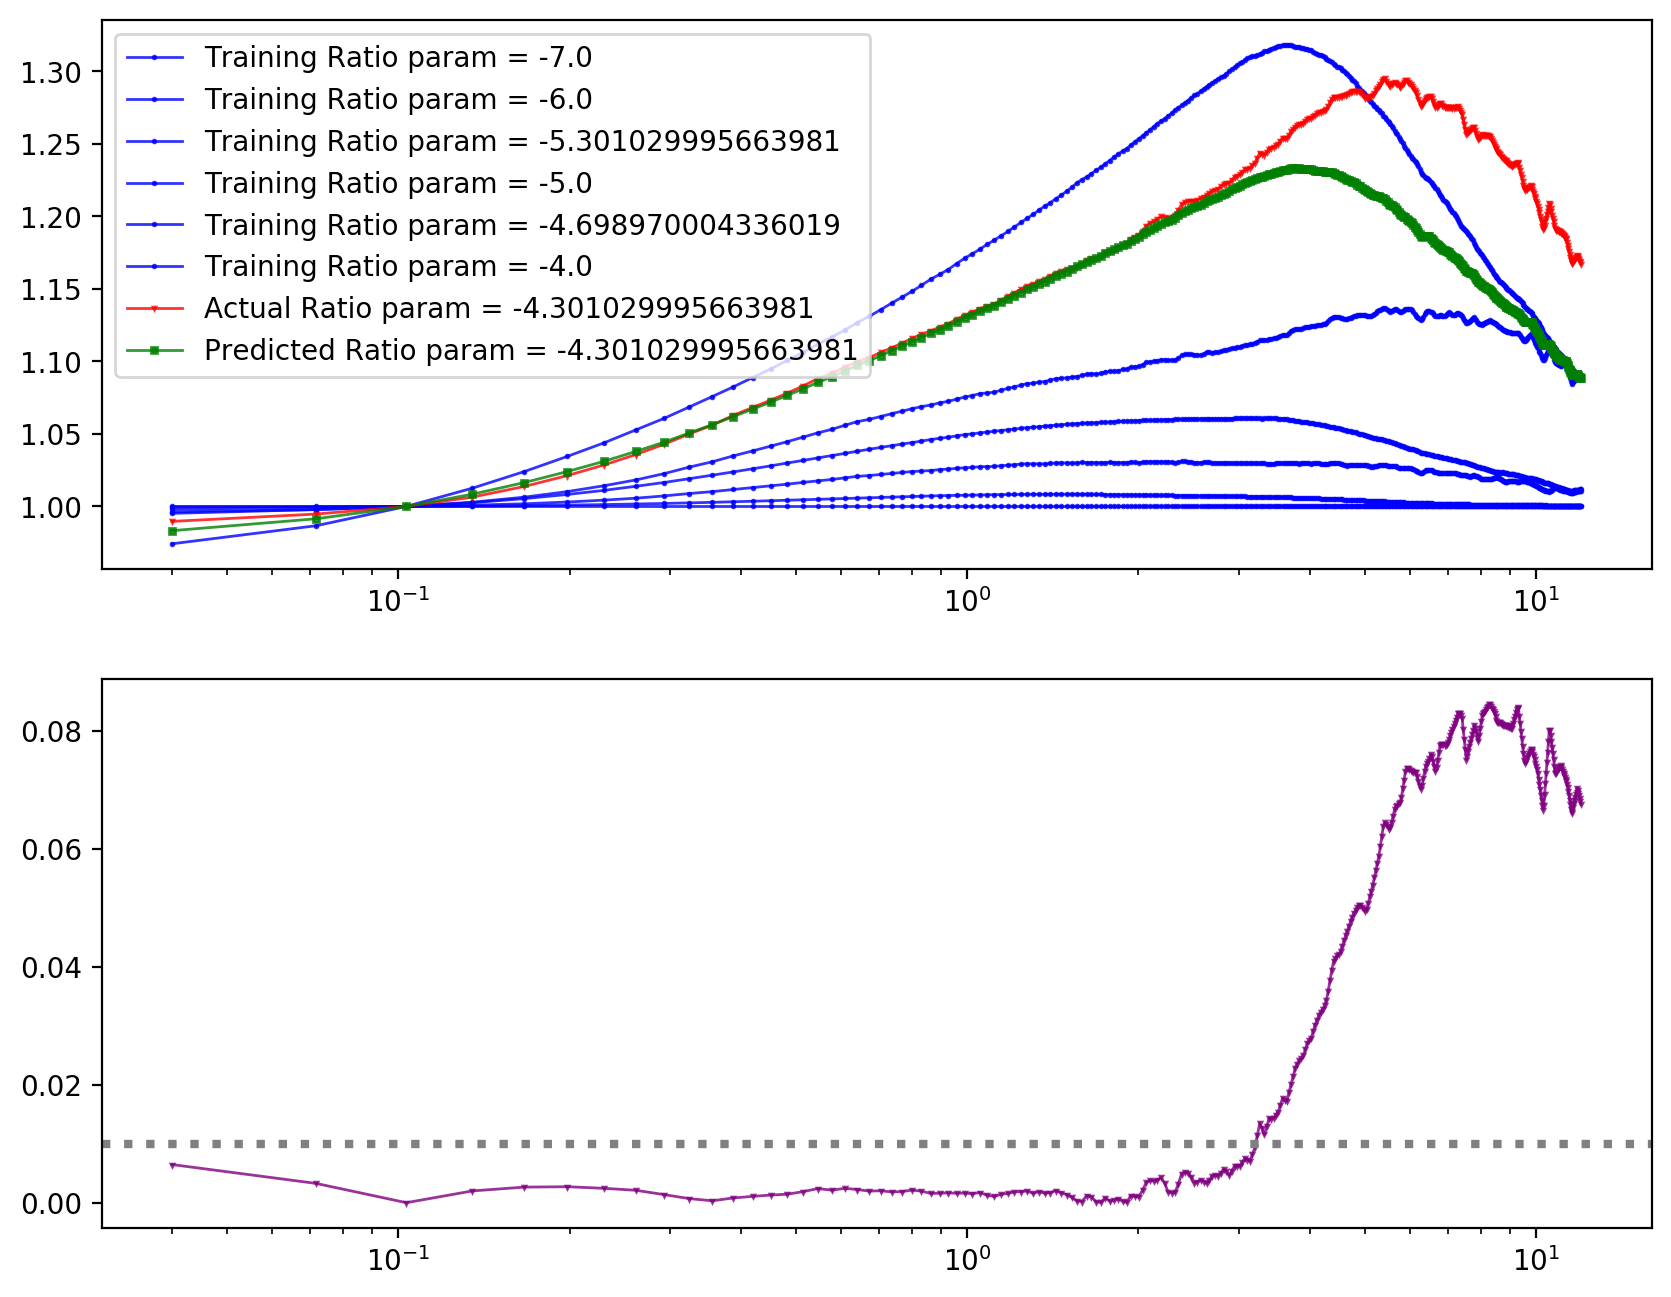

In [157]:
Plot_prediction(emulation_data,emulation_data.test_samples[0], ratios_predicted, abs_res=True)

# Apply a mask to ignore some values

The following example used a mask to ignore the value before k<0.1 

In [158]:
##########################
####Mask large scale####
##########################

linkgrid = np.power(10, emulation_data.k_grid)
mask = np.where(linkgrid < 3)[0]
GLOBAL_applymask = True
thinning = 1

('number of obtained training vectors', 6)
('number of obtained validation vectors', 0)
('Shape of PCA matrix: (6, 6)',)
('Number of PCA components: 6',)
 global mean min error:  0.0 
 global mean max error:  0.006465152455374852 
 global max rmse:  0.0033605087530229226 
 global mean rmse:  0.0033605087530229226 
 global var rmse:  0.0


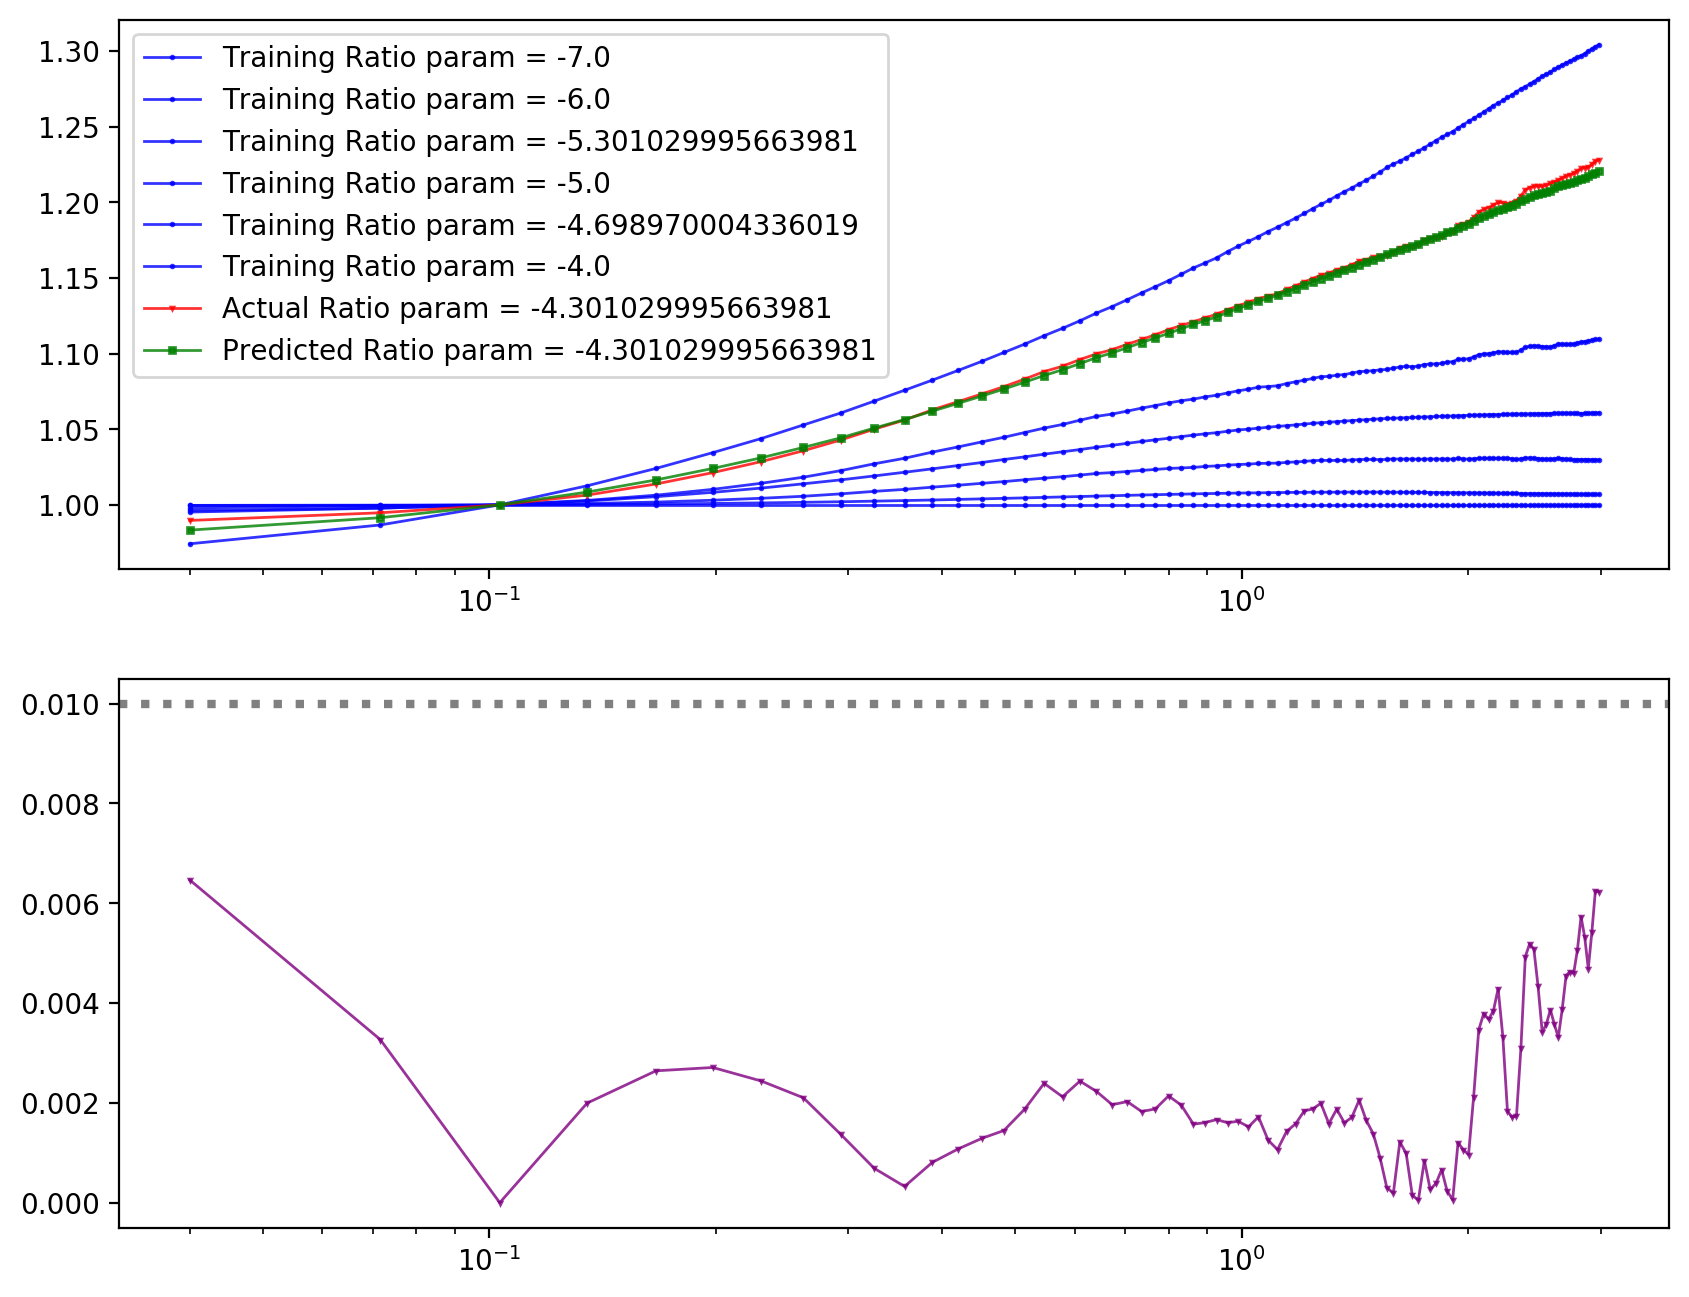

In [160]:
emulation_data.data_split(split_index=4,thinning=thinning, mask=mask, 
                                              apply_mask=GLOBAL_applymask, verbosity=1)
PCAop = dcl.LearningOperator('PCA', ncomp=npca, interp_type='int1d')
intobj = dcl.LearnData(PCAop)

###Perfoming the PCA reduction and interpolation 
intobj.interpolate(train_data=emulation_data.matrix_datalearn_dict["theo"]['train'],
                           train_samples=emulation_data.train_samples)
###Predicting the ratio with the inpolations :

ratios_predicted = intobj.predict(emulation_data.test_samples);
###Simple dictionnary to match parameters respecting to their ratio.

Plot_prediction(emulation_data, emulation_data.test_samples[0],ratios_predicted, abs_res=True)

intobj.calc_statistics(emulation_data.matrix_datalearn_dict.theo['test'],
                                            emulation_data.test_samples)
intobj.print_statistics()

# GP Example

('number of obtained training vectors', 6)
('number of obtained validation vectors', 0)
 global mean min error:  4.780483027977201e-05 
 global mean max error:  0.020595411206087825 
 global max rmse:  0.011762802155058566 
 global mean rmse:  0.011762802155058566 
 global var rmse:  0.0


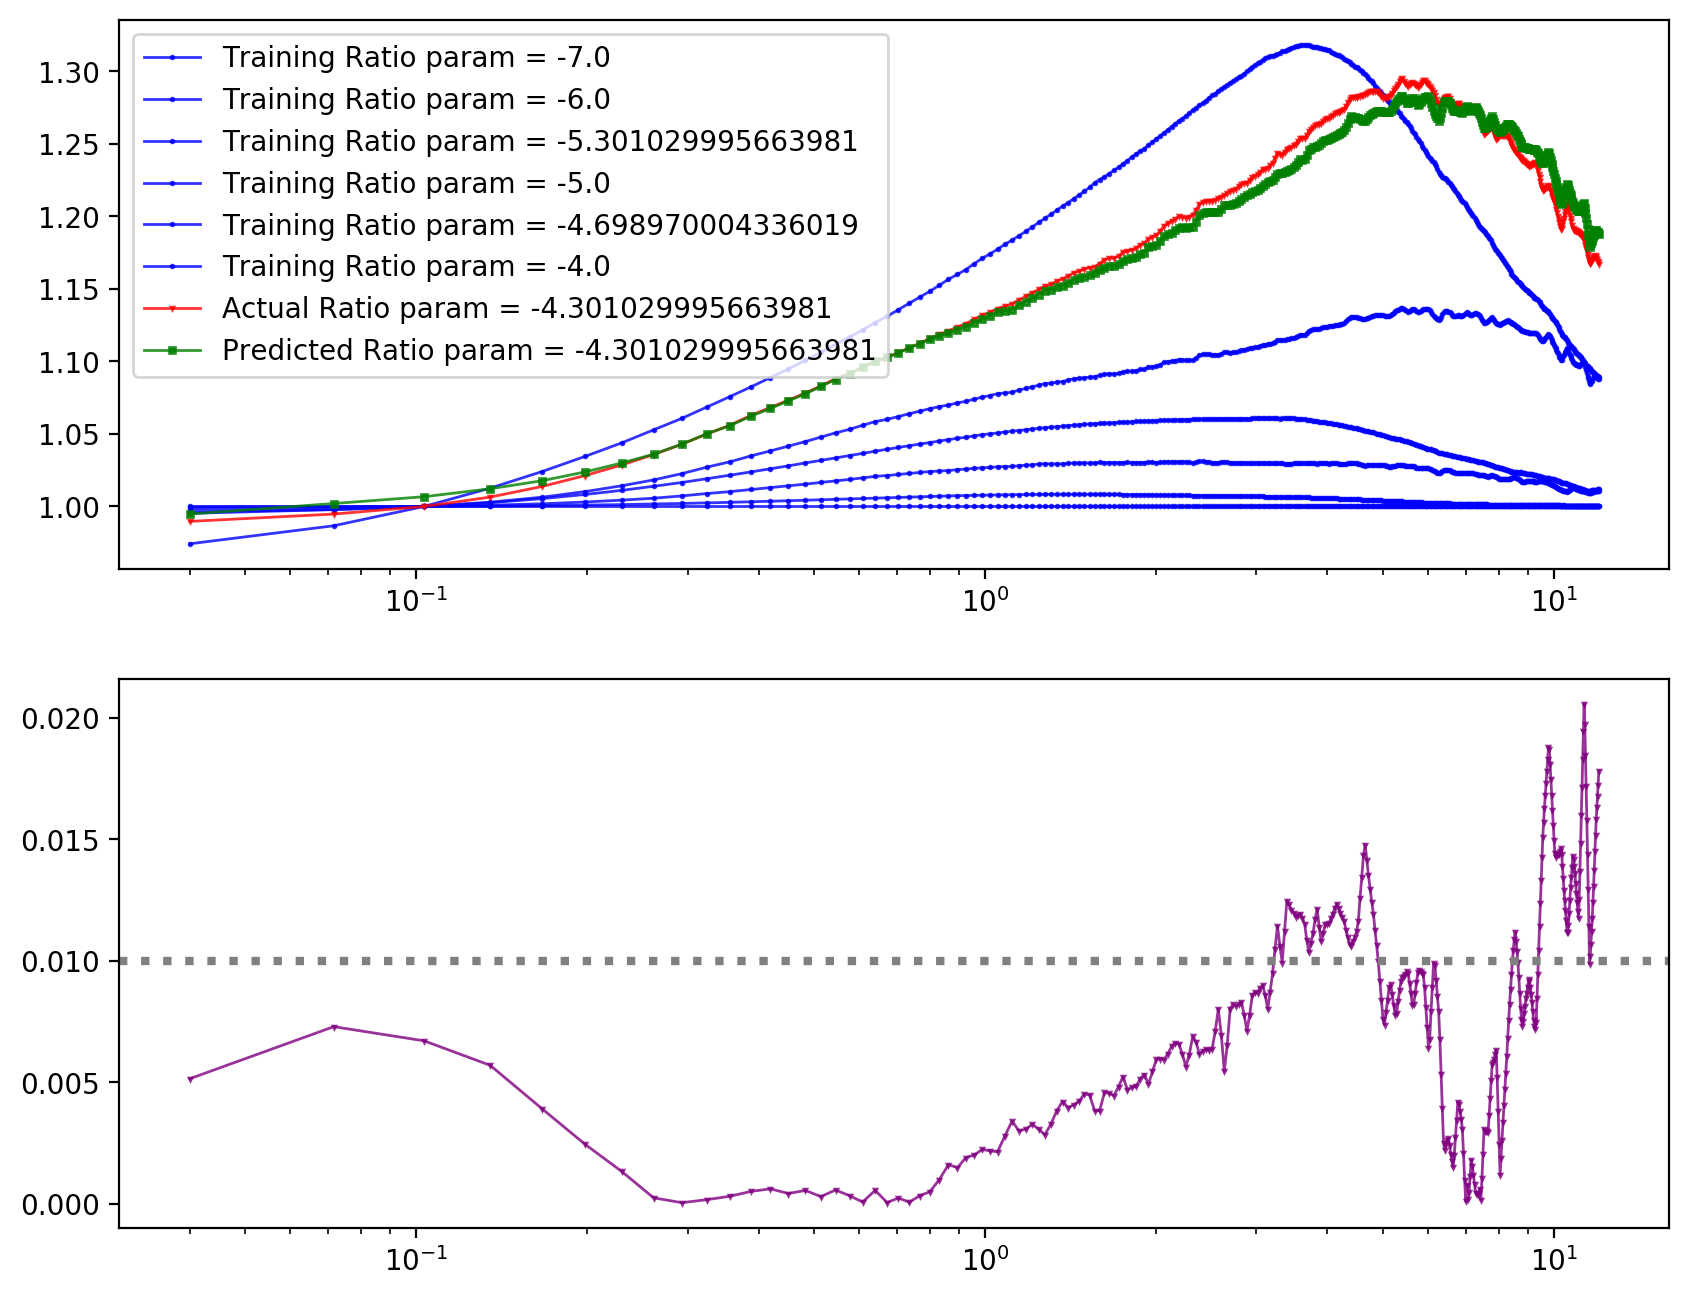

In [162]:
emulation_data.data_split(split_index=4, mask=mask, apply_mask=False)
                                              #apply_mask=GLOBAL_applymask, verbosity=1)
GPop = dcl.LearningOperator('GP')
intobj = dcl.LearnData(GPop)

###Perfoming the PCA reduction and interpolation 
train_data = emulation_data.matrix_datalearn_dict["theo"]['train']
intobj.interpolate(train_data=train_data,
                           train_samples=emulation_data.train_samples)
###Predicting the ratio with the inpolations :

ratios_predicted = intobj.predict(emulation_data.test_samples);
###Simple dictionnary to match parameters respecting to their ratio.

Plot_prediction(emulation_data, emulation_data.test_samples[0],ratios_predicted, abs_res=True)

intobj.calc_statistics(emulation_data.matrix_datalearn_dict.theo['test'],
                                            emulation_data.test_samples)
intobj.print_statistics()

### With Mask

('number of obtained training vectors', 6)
('number of obtained validation vectors', 0)
 global mean min error:  0.00030961981569480144 
 global mean max error:  0.017647081660605708 
 global max rmse:  0.015470280252629469 
 global mean rmse:  0.015470280252629469 
 global var rmse:  0.0


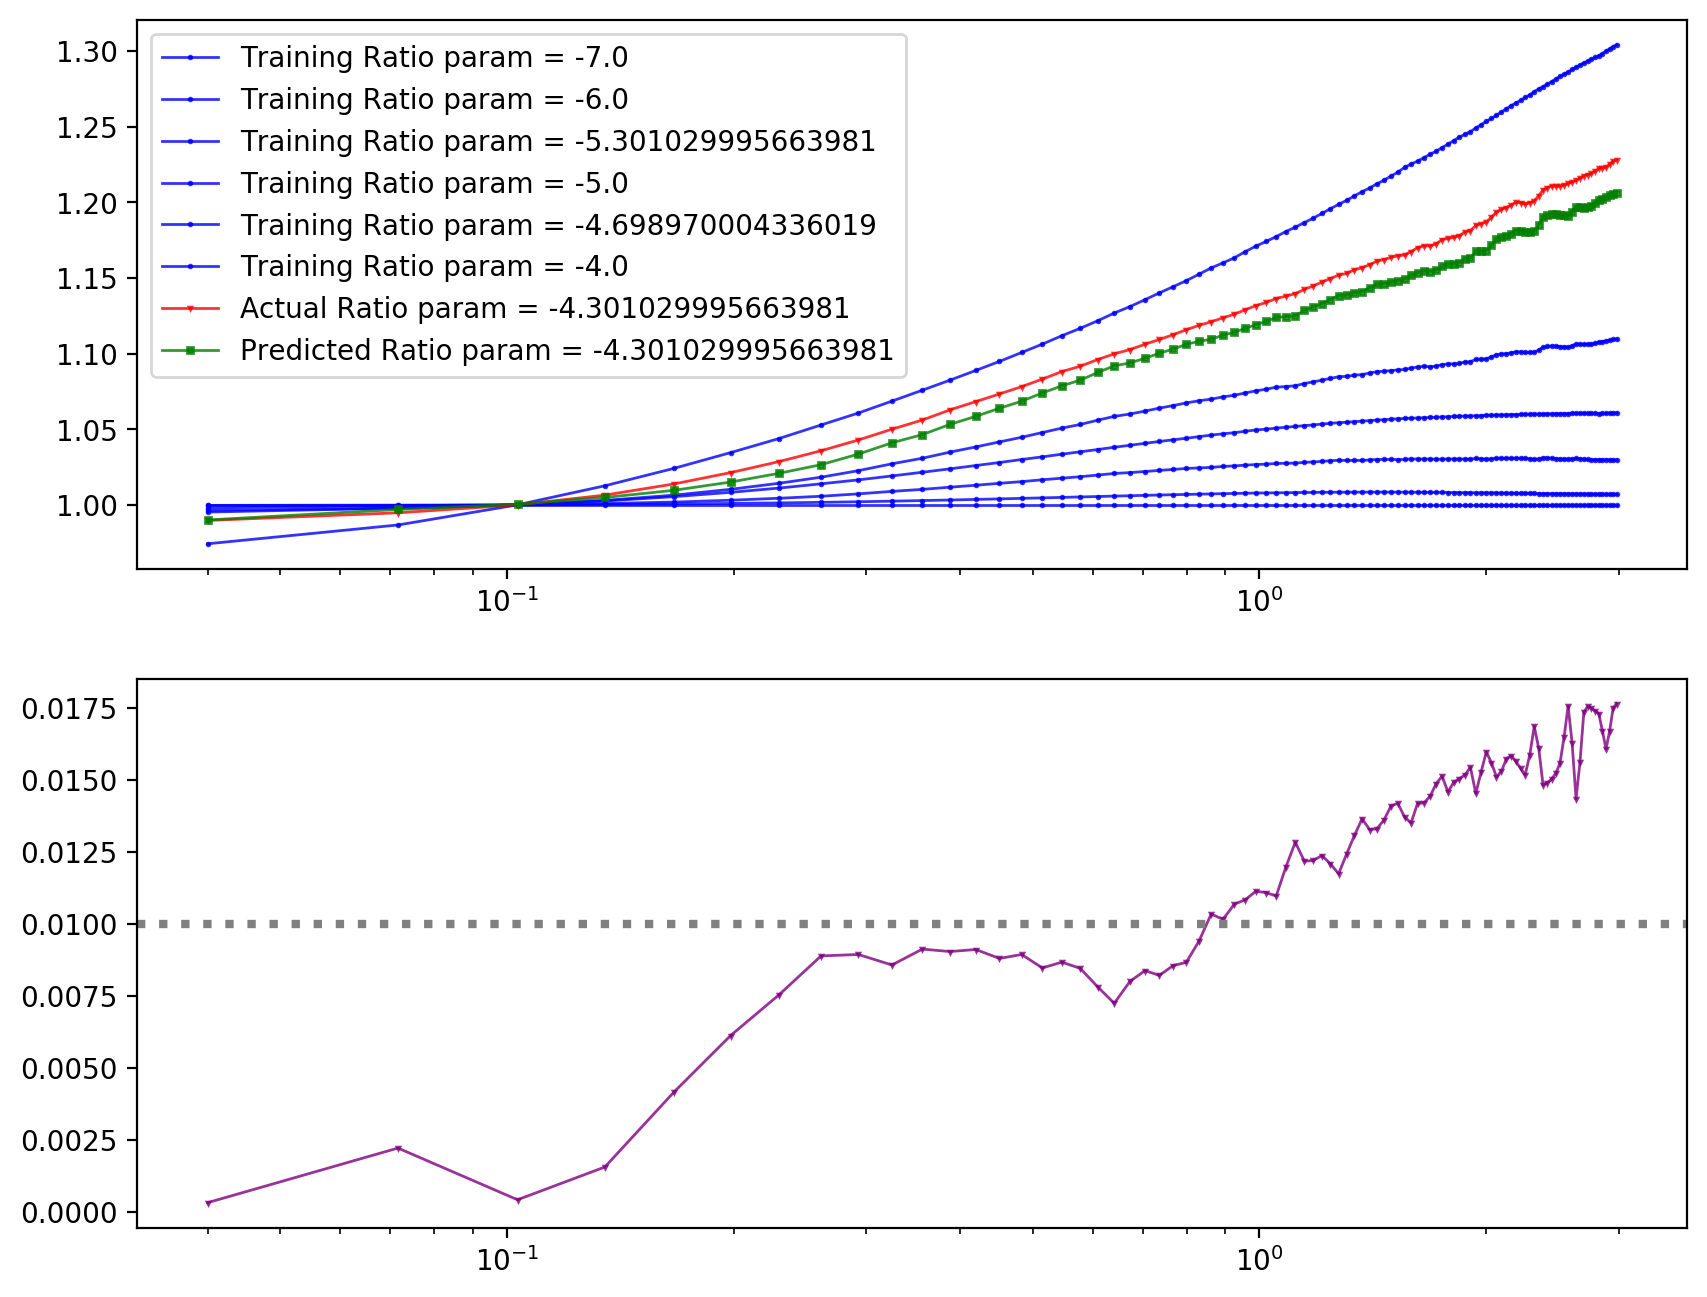

In [163]:
emulation_data.data_split(split_index=4, mask=mask, 
                                              apply_mask=GLOBAL_applymask, verbosity=1)
GPop = dcl.LearningOperator('GP')
intobj = dcl.LearnData(GPop)

###Perfoming the PCA reduction and interpolation 
train_data = emulation_data.matrix_datalearn_dict["theo"]['train']
intobj.interpolate(train_data=train_data,
                           train_samples=emulation_data.train_samples)
###Predicting the ratio with the inpolations :

ratios_predicted = intobj.predict(emulation_data.test_samples);
###Simple dictionnary to match parameters respecting to their ratio.

Plot_prediction(emulation_data, emulation_data.test_samples[0],ratios_predicted, abs_res=True)

intobj.calc_statistics(emulation_data.matrix_datalearn_dict.theo['test'],
                                            emulation_data.test_samples)
intobj.print_statistics()

# Residual plots

Functions used to plot

In [194]:
def ax_residual(ax,color,emulation_data, paramvalue_predicted, ratios_predicted,
                   abs_res=False, plot_hline=True, horizontal_y=0.01) :
    
    if emulation_data.masked_k_grid is not None:
        k_grid=np.power(10,emulation_data.masked_k_grid)
    else:
        k_grid=emulation_data.lin_k_grid

    
    #ratio_train_dict=dict(zip(emulation_data.train_samples,emulation_data.matrix_datalearn_dict["theo"]["train"]))
    ratio_test_dict=dict(zip(emulation_data.test_samples,emulation_data.matrix_datalearn_dict["theo"]["test"]))
    
    
    paramvalue = paramvalue_predicted
    #plt.plot(kgrid_cod,emu_beta_EXP_codec/powerLCDM_cod)
    #plt.xscale('log')
    residual = 1-ratios_predicted[paramvalue]/ratio_test_dict[paramvalue]
    if abs_res:
        residual = np.abs(residual)
    ax.semilogx(k_grid, residual,'-v', 
               color=color, lw=1, ms=1, markevery=1, 
         alpha=0.8, label="Residual param = "+ '{:.3f}'.format(paramvalue))
    if plot_hline:
        ax.axhline(horizontal_y, color='g', ls=':', lw='3')
    ax.legend(loc='upper left')
    return ax


def plot_residuals_for_tests_vectors(n_train, n_test, n_splits=5, mask_kvalue=3.0, Op_name ="PCA"):
    test_indices=list(range(1, n_splits+1))
    emulation_data.calculate_data_split(n_train, n_test, 
                                        n_splits=n_splits  , verbosity=0,
                                        test_indices=test_indices,
                                        manual_split=True)
    linkgrid = np.power(10, emulation_data.k_grid)
    mask_1 = np.where(linkgrid < mask_kvalue)[0]


    fig,ax =plt.subplots(2, figsize=(10,8), dpi=200,facecolor='w')
    font = {'fontname':'Times'} 
    
    fig.tight_layout(pad=6.0)
    for i in range(2):
        ax[i].set_title("Residual Error with "+Op_name,**font)
        ax[i].set_xlabel("$k [Mpc^{-1}]$",**font)  
        ax[i].set_ylabel("Error residuals on $P_F(k)/P_{LCDM}(k)$",**font) 
        
    def plot_residual(ax,emulation_data,n_splits,thinning, mask, GLOBAL_applymask):
        for i in range(n_splits) :#,):
            emulation_data.data_split(split_index=i,thinning=thinning, mask=mask, 
                                                          apply_mask=GLOBAL_applymask, verbosity=0)
            Op = dcl.LearningOperator(Op_name, ncomp=n_train, interp_type='int1d',verbosity=0)
            intobj = dcl.LearnData(Op)

            ###Perfoming the PCA reduction and interpolation 
            intobj.interpolate(train_data=emulation_data.matrix_datalearn_dict["theo"]['train'],
                                       train_samples=emulation_data.train_samples)
            ###Predicting the ratio with the inpolations :
            ratios_predicted = intobj.predict(emulation_data.test_samples);
            ###Simple dictionnary to match parameters respecting to their ratio.


            ax_residual(ax,np.array([1*(i/n_splits),0,1*1]),emulation_data, emulation_data.test_samples[0],ratios_predicted, abs_res=True)
    
    plot_residual(ax[0],emulation_data,n_splits,None, None, False)
    plot_residual(ax[1],emulation_data,n_splits,None, mask_1, True)
    ax[0].set_xlim(4e-2,12)
    ax[1].set_xlim(4e-2,12)
    ax[0].axvline(3.0, ls=":", color="gray")
    ax[0].set_ylim(0,0.09)
    ax[1].set_ylim(0,0.09)

## Plot the residuals for PCA

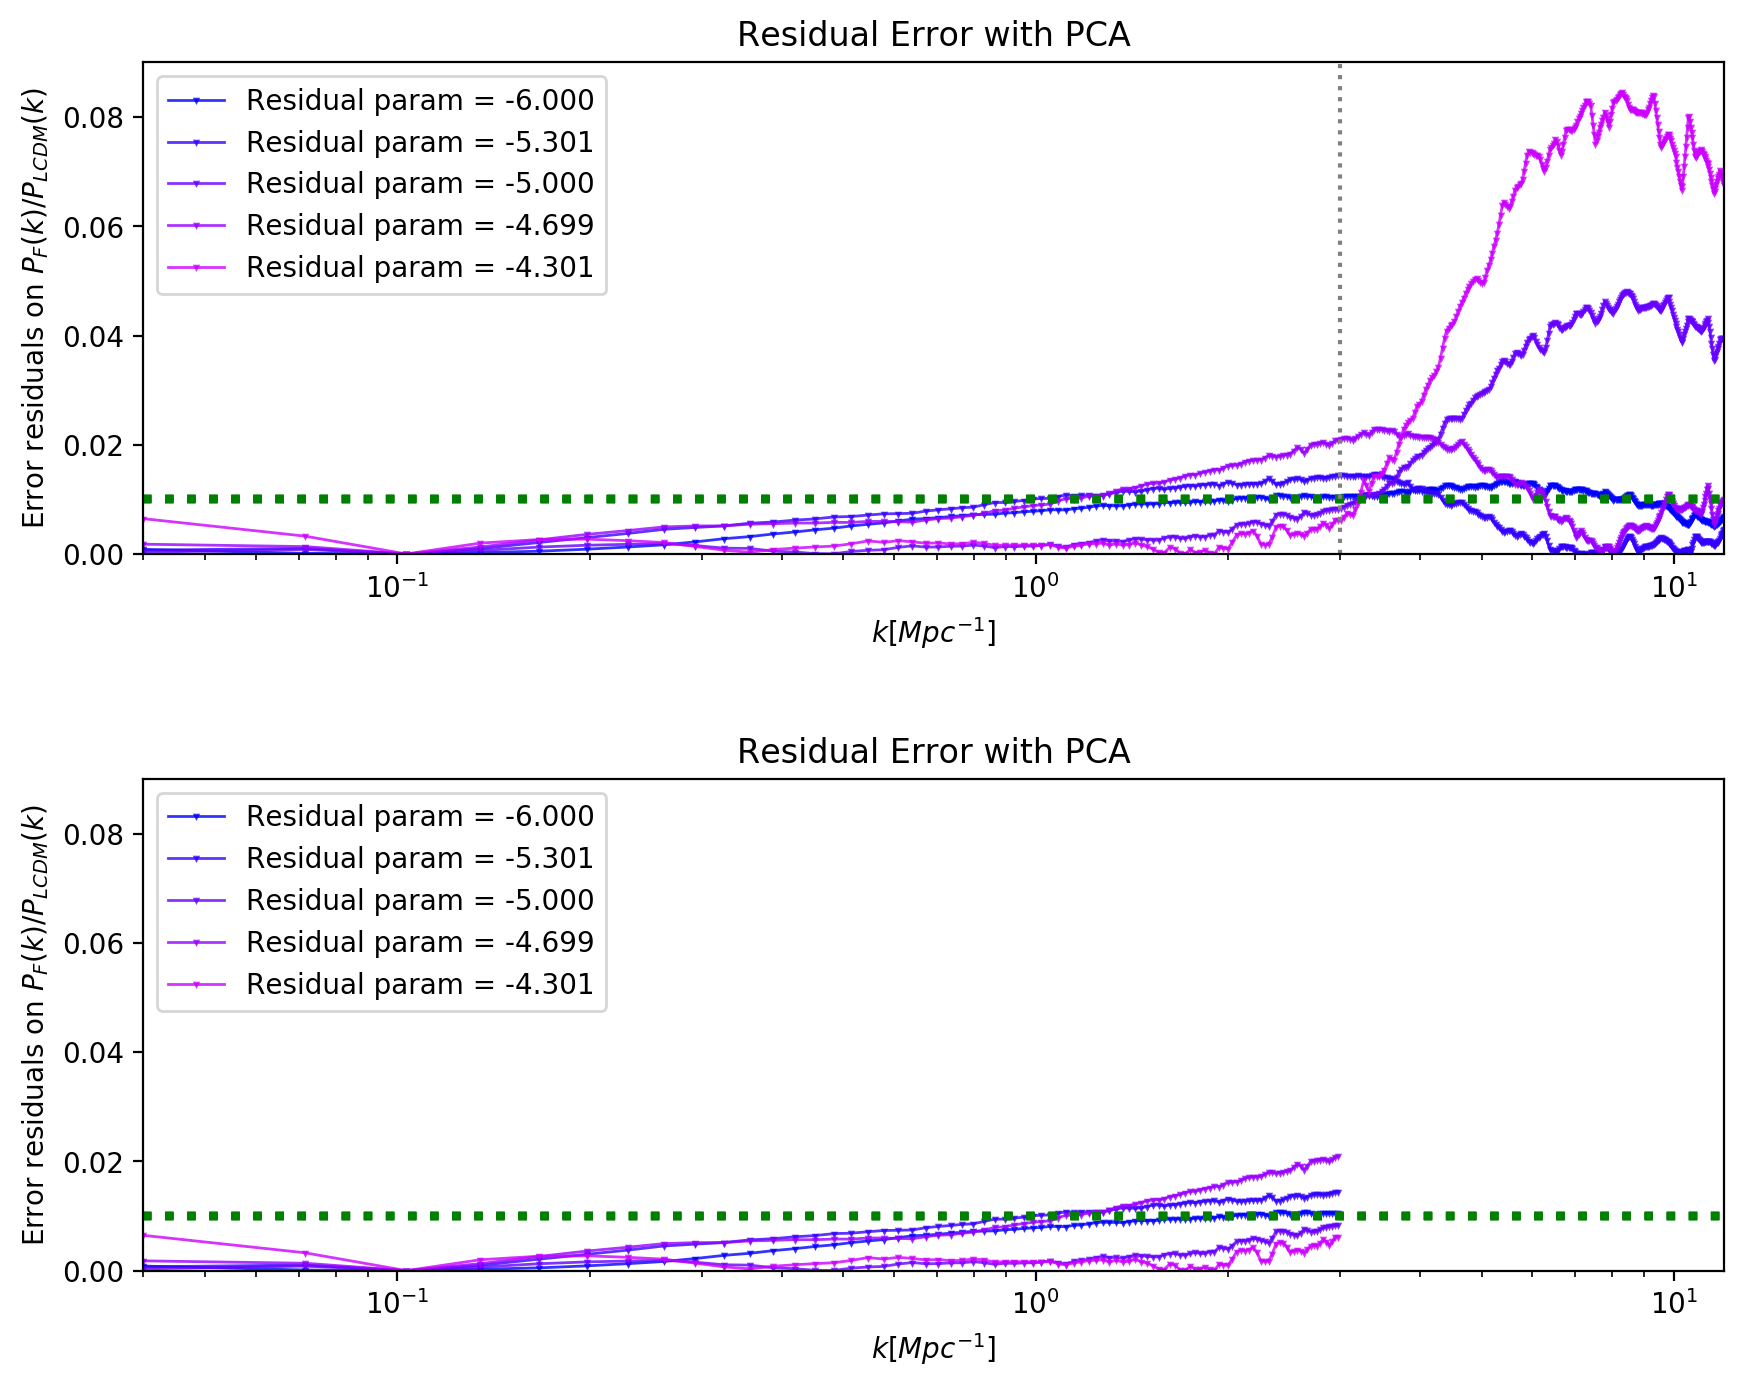

In [196]:
plot_residuals_for_tests_vectors(6, 1, 5)

In [199]:
#plot_residuals_for_tests_vectors(4, 1, 3)

## Plot Residual for GP

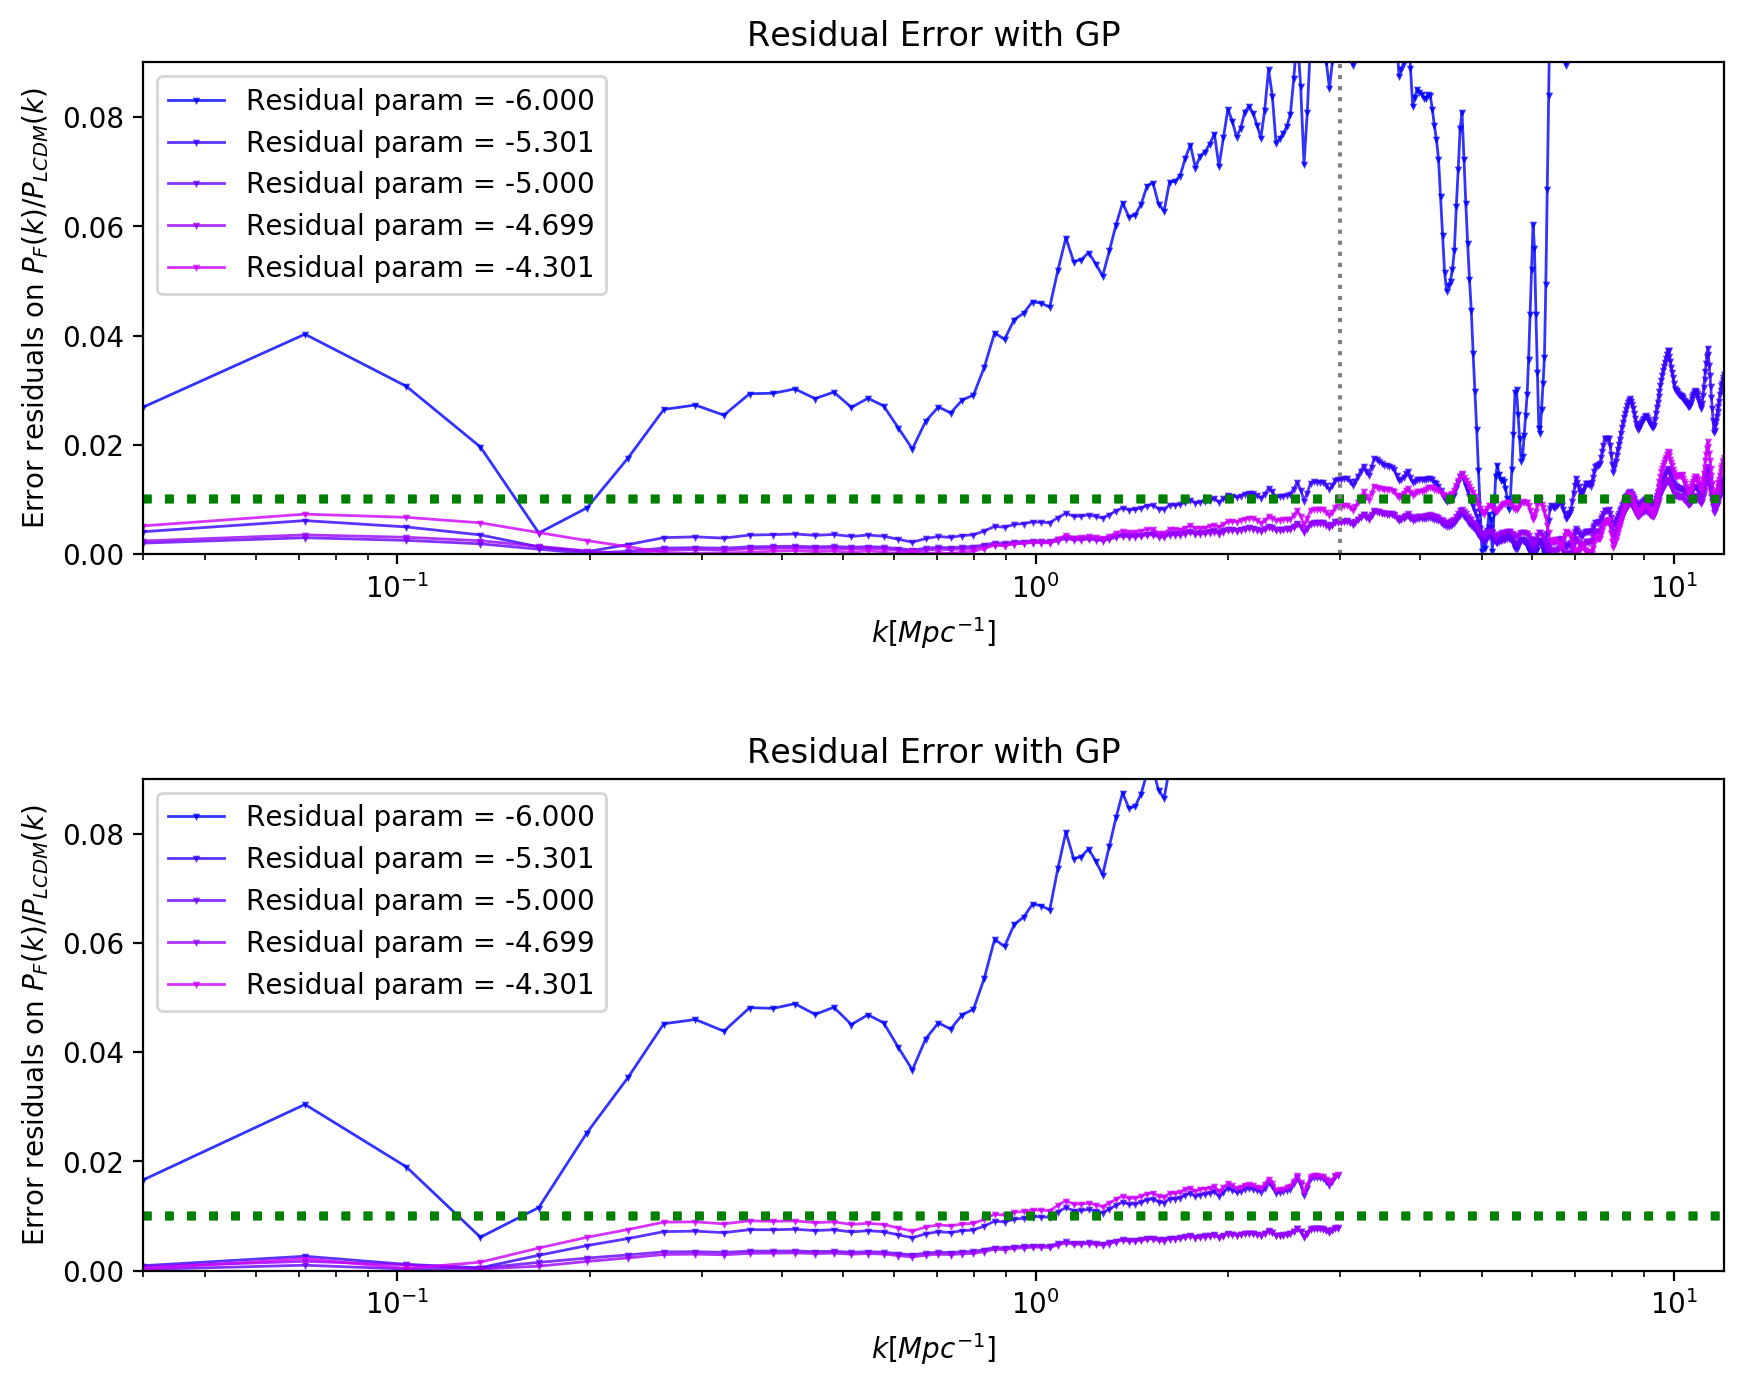

In [201]:
plot_residuals_for_tests_vectors(6,1, Op_name="GP")

# LIN

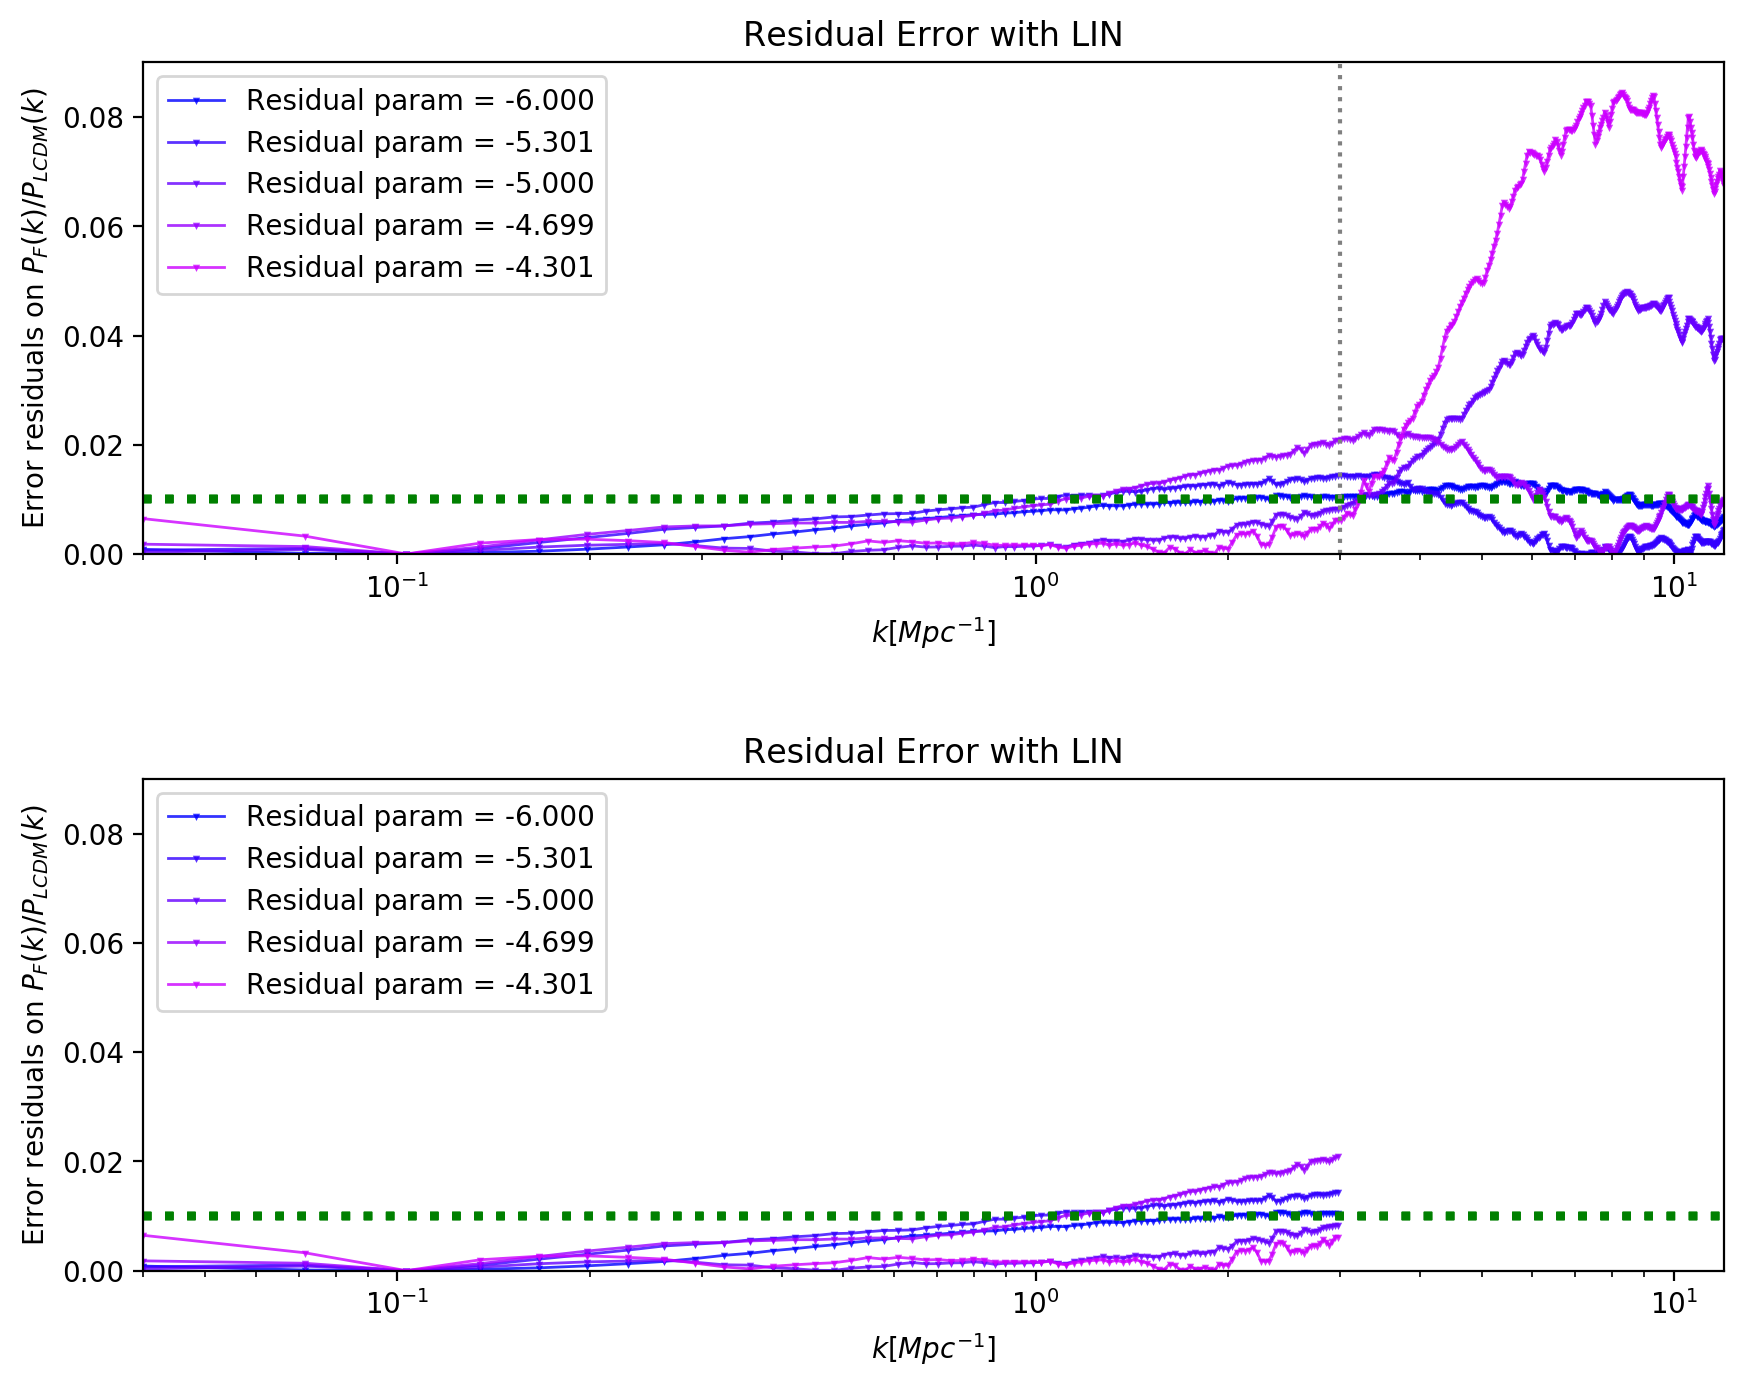

In [202]:
plot_residuals_for_tests_vectors(6,1, Op_name="LIN")

# DL

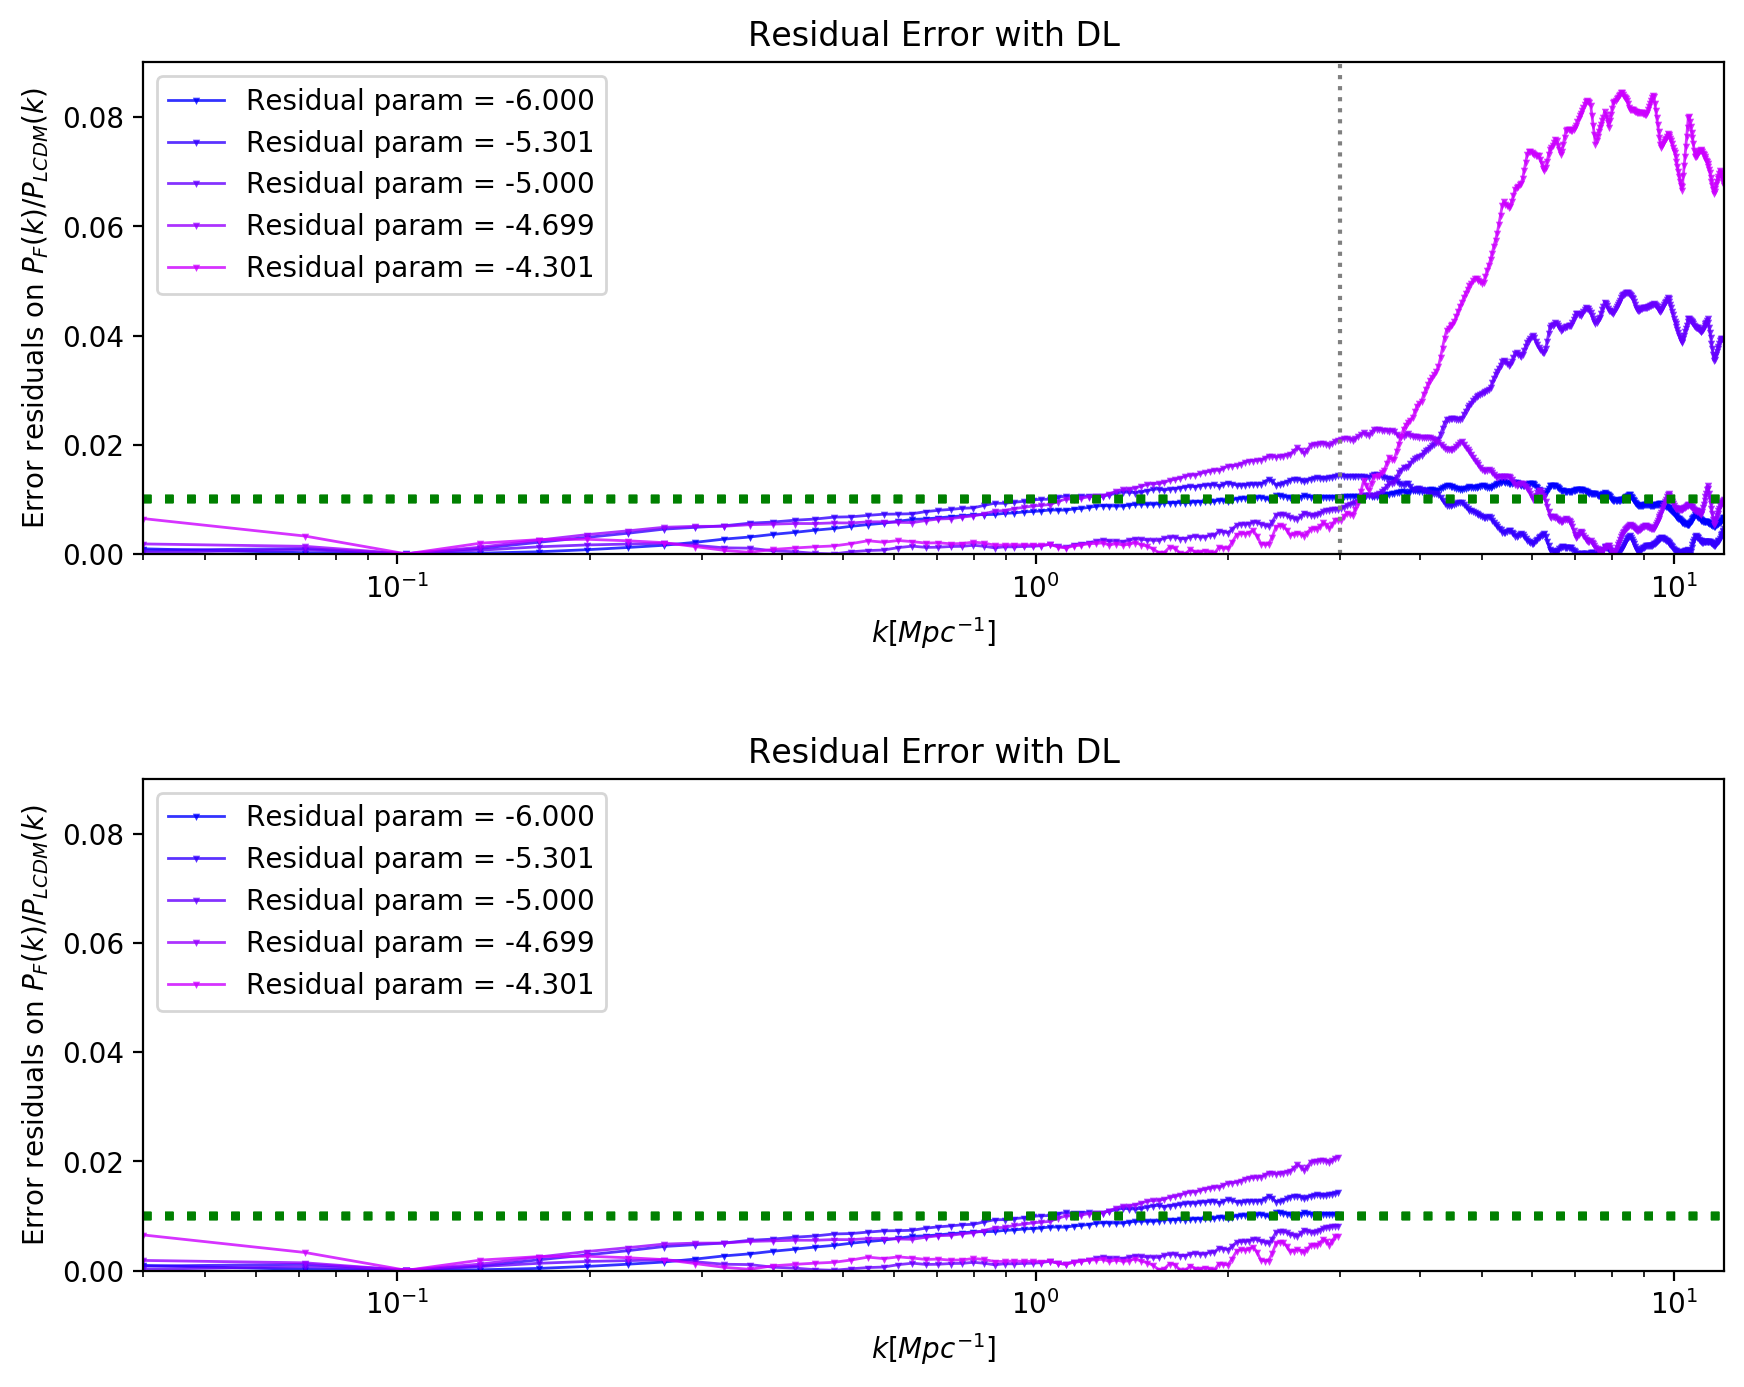

In [203]:
plot_residuals_for_tests_vectors(6,1, Op_name="DL")

# RMSE plots (must be updated)

The function plot_RMSE provide of dictionnary mapping the test parameters to its RMSE averaged as a function of the number of train vectors .
For each split the test vectors and train vectors may change. Then two splits can contain the same test vectors but used different train vectors so the perfomance won't be the same on this test vector. Therefore we need to average over the split

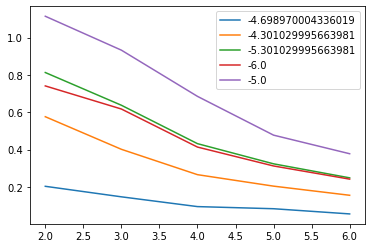

In [32]:
maxtrain = 5

dic_RMSE = plot_RMSE(maxtrain, num_splits=14)
for key in dic_RMSE.keys():
    plt.plot([k for k in range(2,maxtrain+2)] , dic_RMSE[key], label=str(key) )
plt.legend()

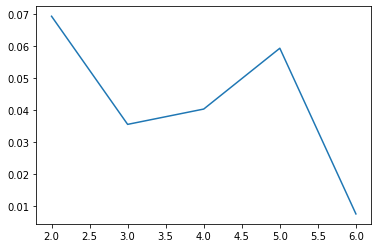

In [33]:

dic_RMSE = plot_RMSE(maxtrain,Op="GP")
for key in dic_RMSE.keys():
    plt.plot([k for k in range(2,maxtrain+2)] , dic_RMSE[key] )    


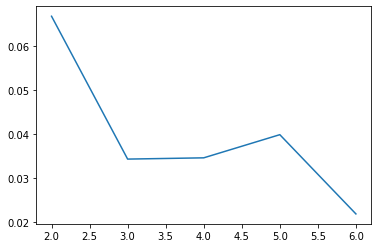

In [34]:
dic_RMSE = plot_RMSE(maxtrain,filtering=True)
for key in dic_RMSE.keys():
    plt.plot([k for k in range(2,maxtrain+2)] , dic_RMSE[key] )

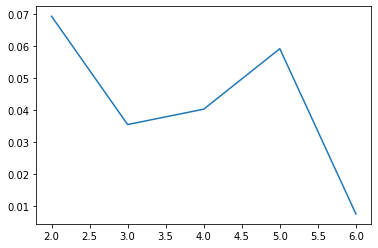

In [35]:
dic_RMSE = plot_RMSE(maxtrain,Op="GP",filtering=True)
for key in dic_RMSE.keys():
    plt.plot([k for k in range(2,maxtrain+2)] , dic_RMSE[key] )